# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
from os import makedirs
from os.path import isfile, isdir, join, exists

data_dir   = './data'
prefix     = '.'
pkl_folder = 'pkl-files'
pkl_prefix = join(prefix, pkl_folder)

pkl_sub    = 'saved_var_checkpoint'                  #sub-folder
pkl_subpth = join(pkl_prefix, pkl_sub)       #filename will be added at runtime 

chk_folder = 'checkpoints'
chk_prefix = join(prefix, chk_folder)

chk_sub    = 'historic_losses'                       #sub-folder
chk_subpth  = join(chk_prefix, chk_sub)       #filename will be added at runtime

f_names = [chk_subpth, pkl_subpth, data_dir]

for foldername in f_names:
    if not exists(foldername):
        makedirs(foldername)

if not isdir(pkl_subpth):
    raise Exception("pkl directory doesn't exist!")
if not isdir(chk_subpth):
    raise Exception("Checkpoints directory doesn't exist!")

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

       
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
# pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
# pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), \
'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/gertadam/anaconda/envs/TensorFlow/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    real_dim      = (image_width, image_height, image_channels)
    inputs_real   = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z      = tf.placeholder(tf.float32, (None, z_dim),     name='input_z')
    learning_rate = tf.placeholder(tf.float32, None,              name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def leaky_relu(r, alpha=0.2):
    return tf.maximum(alpha * r, r)

def array_product(array):
    result = 1
    for n in array:
        result *= int(n)
    return result

In [8]:
Dkeep_prob      = 0.5            # initialize

def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    global Dkeep_prob            
    
    kernel_init = tf.contrib.layers.xavier_initializer()
    
    # no batch norm on the 1st layer
    with tf.variable_scope('discriminator', reuse=reuse):
        kernel_size = 4
        conv1 = tf.layers.conv2d(images, 128, kernel_size, strides=2, padding='same', kernel_initializer=kernel_init)
        drop1 = tf.layers.dropout(conv1, Dkeep_prob)
        leak1 = leaky_relu(drop1, alpha=alpha)
        #print("leak1.sh",leak1.shape) #leak1.sh (?, 14, 14, 128)
        
        conv2 = tf.layers.conv2d(leak1, 256, kernel_size, strides=2, padding='same', kernel_initializer=kernel_init)
        drop2 = tf.layers.dropout(conv2, Dkeep_prob)
        bnor2 = tf.layers.batch_normalization(drop2, training=True)
        leak2 = leaky_relu(bnor2, alpha=alpha)
        #print("leak2.sh",leak2.shape) # leak2.sh (?, 7, 7, 256)
        
        conv3 = tf.layers.conv2d(leak2, 512, kernel_size, strides=2, padding='same', kernel_initializer=kernel_init)
        drop3 = tf.layers.dropout(conv3, Dkeep_prob)
        bnor3 = tf.layers.batch_normalization(drop3, training=True)
        leak3 = leaky_relu(bnor3, alpha=alpha)
        #print("leak3.sh",leak3.shape) # leak3.sh (?, 4, 4, 512)
    
        shape4 = tf.reshape(leak3, [-1, array_product(leak3.get_shape()[1:])])
        #print("shape4.sh",shape4.shape) # shape4.sh (?, 8192)
        
        logits = tf.layers.dense(shape4, 1)
        output = tf.sigmoid(logits)
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [39]:
Gkeep_prob      = 0.4            # initialize

def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # I've expanded this gradually, but significantly in order to strengthen G
    # to give G "more room" for learning (and for dropout - to stabil.)
    
    # print("z", z.shape)                    # z (?, 100)
    # target (28,28, out_channel_dim)

    # Gkeep_prob -another tool we use to make the G more steady, less irratic, less dependent on D
    global Gkeep_prob
    # kernel_size 1, 2, 4, 8
    kernel_init = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope('generator', reuse=not is_train): 

        dense = tf.layers.dense(z, 2*2*4096)
        # print("dense", dense.shape)       # dense (?, 16384)
        
        shape1 = tf.reshape(dense, [-1, 2, 2, 4096])
        
        if is_train:
            drop1  = tf.layers.dropout(shape1, Gkeep_prob)
        else:
            drop1  = tf.layers.dropout(shape1, 1)
            
        bnor1  = tf.layers.batch_normalization(drop1, training=is_train)
        leak1  = leaky_relu(bnor1)
        # print("leak1", leak1.shape)       # leak1 (?, 2, 2, 4096)

        # inspired by http://distill.pub/2016/deconv-checkerboard/
        bili1  = tf.image.resize_images(leak1, [3, 3])    # default method=ResizeMethod.BILINEAR
        # print("bili1", bili1.shape)       # bili1 (?, 3, 3, 4096)
        
        tran1  = tf.layers.conv2d_transpose(bili1, 2048, 1, strides=1, padding='same', \
                                            kernel_initializer=kernel_init)
        # print("tran1",tran1.shape)        # tran1 (?, 3, 3, 2048)
        if is_train:
            drop2  = tf.layers.dropout(tran1, Gkeep_prob)
        else:
            drop2  = tf.layers.dropout(tran1, 1)
            
        bnor2  = tf.layers.batch_normalization(drop2, training=is_train)
        leak2  = leaky_relu(bnor2)
        # print("leak2", leak2.shape)       # leak2 (?, 3, 3, 2048)
        
        bili2  = tf.image.resize_images(leak2, [7, 7])    # default method=ResizeMethod.BILINEAR
        # print("bili2", bili2.shape)       # bili2 (?, 7, 7, 2048)
        
        tran2  = tf.layers.conv2d_transpose(bili2, 1024, 2, strides=1, padding='same', \
                                            kernel_initializer=kernel_init)
        # print("tran2",tran2.shape)        # tran2 (?, 7, 7, 1024)
        
        # while still trying to stabilize G - I try less Drops in the lower G: inspired by: 
        # https://medium.com/towards-data-science/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0
        bnor3  = tf.layers.batch_normalization(tran2, training=is_train)
        leak3  = leaky_relu(bnor3)
        # print("leak3", leak3.shape)       # leak3 (?, 7, 7, 1024)
        
        bili3  = tf.image.resize_images(leak3, [14, 14])    # default method=ResizeMethod.BILINEAR
        # print("bili3", bili3.shape)       # bili3 (?, 14, 14, 1024)
                
        tran3  = tf.layers.conv2d_transpose(bili3, 512, 4, strides=1, padding='same', \
                                            kernel_initializer=kernel_init)
        # print("tran3",tran3.shape)        # tran3 (?, 14, 14, 512)
        
        bnor4  = tf.layers.batch_normalization(tran3, training=is_train)
        leak4  = leaky_relu(bnor4)
        
        bili4  = tf.image.resize_images(leak4, [28, 28])    # default method=ResizeMethod.BILINEAR
        # print("bili4", bili4.shape)     # bili4 (?, 28, 28, 512)
                        
        logits = tf.layers.conv2d_transpose(bili4, out_channel_dim, 8, strides=1, padding='same')
        # print("logits",logits.shape)    # logits (?, 28, 28, 5)
        
        # print("chan",out_channel_dim)   # chan 5
        output = tf.tanh(logits)

    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [40]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # no longer two GPU's 
    # with tf.device(gpu1):
    g_model = generator(input_z, out_channel_dim)
    
    # with tf.device(gpu0):
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    d_loss_real = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                            labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                            labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                            labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [41]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        # with tf.device(gpu0):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        # with tf.device(gpu1):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [42]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()


### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [43]:
import pickle as pkl

import time
import datetime
from datetime import timedelta 

def timestmp():
    print ("tmstmp")
    print (datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
def split(start_time):
    split_time = time.time()
    time_dif   = split_time - start_time
    time_str = str(timedelta(seconds = int(time_dif)))
    return time_dif, time_str
    

In [44]:
import pylab 
import numpy as np

def plot_loss(losses, steps_graph):
    fig, ax = pyplot.subplots()
    step_list = [x* steps_graph for x in range(len(losses))]
    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()
    pyplot.show()
    

In [49]:
#from laplotter import LossAccPlotter
from collections import deque
import numpy as np

def train(epochs, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epochs: Number of epochs pr. run
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # global
    global filename
    global Load_chk
    global steps_printline
    global steps_images
    global chkfilepth
    global pckfilepth
    global num_mv_avg    
    
    # var
    steps           = 0
    laststeps       = 0
    last_elapsed    = 0
    samples, losses = [], []
    start_time      = time.time()
    mov_av_list     = deque()
    #plotter         = LossAccPlotter()
    
    image_dim = data_shape[1:]
    channels  = image_dim[-1]
    
    image_mode = "L" if channels == 1 else "RGB"
    
    input_real, input_z, lr = model_inputs(*image_dim, z_dim)
    d_loss, g_loss                     = model_loss(input_real, input_z, channels)
    d_opt, g_opt                       = model_opt(d_loss, g_loss, learning_rate, beta1)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver           = tf.train.Saver()
        
        # implemented in train() so I can separate data from the two runs at runtime
        # so we can separate MNIST files from CELEBA-files
        chk_suffix = '.chk'
        chkfilepth = os.path.join(chk_subpth, filename+chk_suffix)
        pkl_suffix = '.pkl'
        pklfilepth = os.path.join(pkl_subpth, filename+pkl_suffix)

        # we need to add .meta - to see that the 3 chkpoint files are present
        metapklfilepth = pklfilepth+'.meta'
        
        if (Load_chk==True):
            # don't know why [isfile] wouldn't work ATM - will have to look into that..
            # ...anyway the model- & losses- restore works even if the isfile doesn't
            saver.restore(sess, chkfilepth)
            print('Model restored.')
            with open(pklfilepth, 'rb') as rl:
                losses = pkl.load(rl)
            print ('historic losses loaded')    
            
            # if isfile(metachkfilepth):
            # else:
                #raise Exception("Cannot find Checkpoint-data file [",metapklfilepth,"] doesn't exist!")
            
            # if isfile(pklfilepth):
            # else:
                # raise Exception("Losses-data file [",pklfilepth,"]doesn't exist!")
                
        timestmp    
        for epoch_i in range(epochs):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Sample noise
                batch_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])
                
                # Optimize
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr: learning_rate})
 
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr: learning_rate})
                
                # 3 xtra optimizations inspired by the chats on SLACK and the orig. GAN paper
                # this is an attempt at stabilizing the Generator and countering the Discriminator overpowering
                # the Generator 
                # so the G takes 1 little steps towards optimum - recalc 
                # - and 1 step towards opt - recalc. (4 times) (so even at a relatively small lr G should learn)
                # -- while D take one on the same batch
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr: learning_rate})
                
                if steps % steps_printline == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    elapsed_time, time_str = split(start_time)
                    elapsed_steps  = steps-laststeps
                    step_time      = elapsed_time-last_elapsed
                    st_time_str = str(timedelta(seconds = int(step_time)))
                    time_rest      = (elapsed_time/(epoch_i+1))*(epochs-epoch_i)/60
                    
                    if (len(mov_av_list)>num_mv_avg):
                        mov_av_list.popleft()
                        mov_av_list.append(time_rest)
                    else:
                        mov_av_list.append(time_rest)
                    mov_av = np.mean(mov_av_list)
                    
                    print("Epoch:{:2}/{:2}".format(epoch_i+1, epochs),
                          "Time: {:8}s.".format(time_str),
                          "st_Tm: {:8}s.".format(st_time_str),
                          "#Steps:{:4},".format(steps),
                          "DLoss:{:7.4f}".format(train_loss_d),
                          "GLoss:{:7.4f}".format(train_loss_g),
                          "guess:{:4.0f}m.".format(time_rest),
                          "average:{:4.0f}m.".format(mov_av))
                    laststeps = steps
                    last_elapsed = elapsed_time 
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if (steps == 1) or (steps % steps_images == 0): 
                    show_generator_output(sess, 81, input_z, channels, image_mode)
                    print()
                    if (Load_chk==True):
                        plot_loss(losses, steps_graph)
                if (steps % steps_graph == 0):
                    print()
                    plot_loss(losses, steps_graph)
                    #
                    saver.save(sess, chkfilepth)
                    timestmp
                    print("checkpoint saved")
                    #
                    print("losses saved to: ",pklfilepth)    
                    with open(pklfilepth, 'wb') as wl:
                        pkl.dump(losses, wl)
                    
        saver.save(sess, chkfilepth)
        timestmp
        print("checkpoint saved")
        
        #does not work need to implement LossAccPlotter 
        plot_loss(losses, steps_graph)
        # trying to separate the 3 plots
        for d in range(5, 0, -1):
            print(d)
        show_generator_output(sess, 81, input_z, channels, image_mode)
        for d in range(5, 0, -1):
            print(d)
        show_generator_output(sess, 4, input_z, channels, image_mode)
        for d in range(5, 0, -1):
            print(d)
        show_generator_output(sess, 4, input_z, channels, image_mode)

    print("pickle should open: ",pklfilepth)    
    with open(pklfilepth, 'wb') as wl:
        pkl.dump(losses, wl)
    print ("finished training {} epochs".format(epochs))
    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

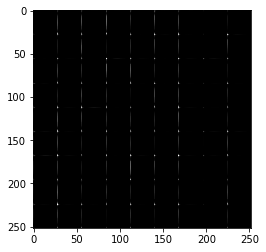


Epoch: 1/ 1 Time: 1:40:15 s. st_Tm: 1:40:15 s. #Steps:  32, DLoss: 0.0000 GLoss:25.8436 guess: 100m. average: 100m.
Epoch: 1/ 1 Time: 3:26:12 s. st_Tm: 1:45:57 s. #Steps:  64, DLoss: 0.0003 GLoss:25.0676 guess: 206m. average: 153m.
Epoch: 1/ 1 Time: 5:14:53 s. st_Tm: 1:48:41 s. #Steps:  96, DLoss: 0.0000 GLoss:24.8263 guess: 315m. average: 207m.
Epoch: 1/ 1 Time: 7:00:58 s. st_Tm: 1:46:04 s. #Steps: 128, DLoss: 0.7271 GLoss: 3.1038 guess: 421m. average: 261m.


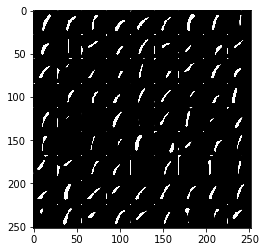

In [ ]:
"""
# GLOBAL VAR 
- rather than changing the params train() uses - I added these params as global 
- which I know is not strictly right, but it works for me.
"""
# std. Hyper param
batch_size    = 128
z_dim         = 100

# I created a spreadsheet to try and understand beta1, beta2, m_0, v_0 - ended up with a 40* higher lr
# I can't say anything other than: these hyperparam worked for me - hope they will for you too.
learning_rate = 0.002
beta1         = 0.5

# to seperate the two data-runs, I will have to give the files different names 
filename      = 'MNIST_run'
Load_chk      = False   # True  set this to [True], if you want to load the checkpoint and ass. losses-file

# https://medium.com/towards-data-science/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0
Gkeep_prob      = 0.4          # more drops, lower keep prob, but with fewer D_O layers (only in the dense)
Dkeep_prob      = 0.4          # lower keep -> to stabilize & weaken D -> to strengthen G

num_mv_avg      =  12 
steps_printline =  32 
steps_images    = 128 

steps_graph     = 256 

# ran 10 previously - now run another 10
epochs          = 1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
#epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [47]:
"""
# GLOBAL VAR 
- rather than changing the params train() uses - I added these params as global 
- which I know is not strictly right, but it works for me.
"""

# std. Hyper param
batch_size     = 256
z_dim          = 100

# I created a spreadsheet to try and understand beta1, beta2, m_0, v_0 - ended up with a 40* higher lr
# I can't say anything other than: these worked for me - hope they will for you too.
learning_rate  = 0.002
beta1          = 0.5

# to seperate the two data-runs, I will have to give the files different names 
filename       = 'CelebA_run'
Load_chk       = False  # True  # set this to [True], if you want to load the checkpoint and ass. losses-file

# https://medium.com/towards-data-science/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0
Gkeep_prob      = 0.4  # more drops -> lower keep prob but with fewer D_O layers (only in the dense)
Dkeep_prob      = 0.4

num_mv_avg      =  24                            
steps_printline =  32
steps_images    = 256 

steps_graph     = 512

# ran 10 previously - now run another 10
epochs          =   1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
#epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

KeyboardInterrupt: 

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.